In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [5]:
from simulation.gen_pend import *

In [6]:
times, trajs = gen_trajs(50_000, 2., .1, np.pi, 3., .0)

In [7]:
trajs.shape

(50000, 2, 20)

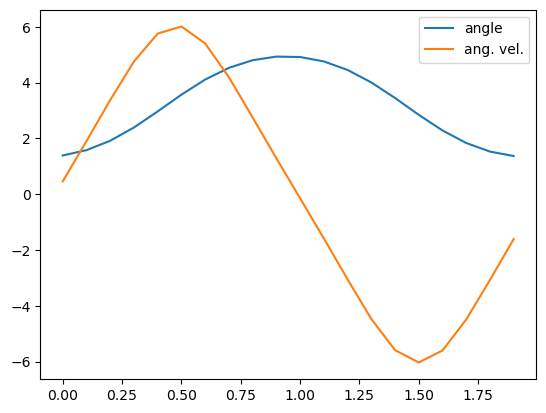

In [13]:
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

Since Pinocchio doesn't give the angles mod 2pi, the angular measurements could get very large. We'll stick to short time-frames so that this doesn't become a problem.

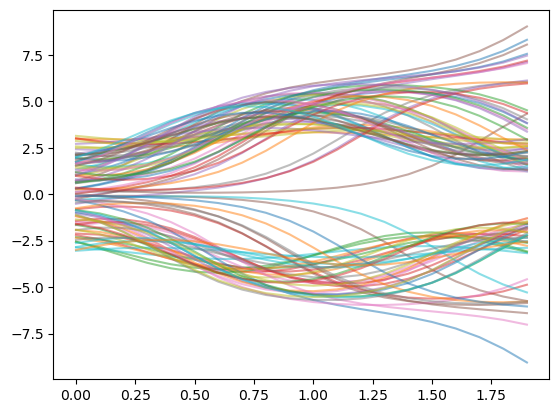

In [14]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Splitting the trajectories into windows

We'll split the trajectories into windows - that way, the MLP architecture won't depend on the length of trajectories to which we apply it.

In [7]:
class TrajWindowsDataset(Dataset):
    def __init__(self, trajs, window):
        super().__init__()
        self.window = window
        self.n_simulations, _, self.n_steps = trajs.shape
        assert window <= self.n_steps
        self.windows_per_traj = self.n_steps - self.window + 1

    def __len__(self):
        return self.n_simulations * self.windows_per_traj

    def __getitem__(self, idx):
        i = idx // self.windows_per_traj
        j = idx % self.windows_per_traj
        return trajs[i, :, j:(j+self.window)]

In [358]:
window = 20
X = TrajWindowsDataset(trajs, window)
dl = DataLoader(X, batch_size=256, shuffle=True)

## MLP

In [100]:
X_tr, X_val = random_split(torch.tensor(trajs), (30_000, 20_000))
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [16]:
class TrajEnc(nn.Module):

    def __init__(self, window, n_features, latent_dim, dropout_rate=0.2):
        super(TrajEnc, self).__init__()

        self.window = window
        self.n_features = n_features

        self.enc = nn.Sequential(
            nn.Linear(window * n_features, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, window * n_features),
        )

    def forward(self, x):
        # x: (bs, n_features, window)
        x = torch.flatten(x, start_dim=1) # x: (bs, n_features * window)
        u = self.enc(x)
        rec = torch.unflatten(self.dec(u), dim=1, sizes=(self.n_features, self.window))
        return rec, u

In [17]:
te = TrajEnc(20, 2, 2)

opt = optim.Adam(te.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in te.parameters())}')

# params: 2050


In [130]:
n_epochs = 500

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    te.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dl_tr):

        opt.zero_grad()
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        loss.backward()
        opt.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(dl_tr.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    te.eval()
    val_loss = 0.0

    for batch_idx, x in enumerate(dl_val):
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(dl_val.dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch [10/500], Tr Loss: 73.4263 Val Loss: 48.9422
Epoch [20/500], Tr Loss: 37.6989 Val Loss: 24.9632
Epoch [30/500], Tr Loss: 24.3196 Val Loss: 16.5517
Epoch [40/500], Tr Loss: 18.8729 Val Loss: 12.9033
Epoch [50/500], Tr Loss: 15.5376 Val Loss: 10.8136
Epoch [60/500], Tr Loss: 13.2843 Val Loss: 9.3126
Epoch [70/500], Tr Loss: 11.6439 Val Loss: 8.1781
Epoch [80/500], Tr Loss: 10.2612 Val Loss: 7.0094
Epoch [90/500], Tr Loss: 9.2681 Val Loss: 6.3511
Epoch [100/500], Tr Loss: 8.4432 Val Loss: 5.9779
Epoch [110/500], Tr Loss: 7.8830 Val Loss: 5.6129
Epoch [120/500], Tr Loss: 7.4008 Val Loss: 5.1084
Epoch [130/500], Tr Loss: 7.1364 Val Loss: 5.1145
Epoch [140/500], Tr Loss: 6.8678 Val Loss: 4.6947
Epoch [150/500], Tr Loss: 6.6923 Val Loss: 4.7088
Epoch [160/500], Tr Loss: 6.4989 Val Loss: 4.3863
Epoch [170/500], Tr Loss: 6.3517 Val Loss: 4.4180
Epoch [180/500], Tr Loss: 6.2318 Val Loss: 4.3132
Epoch [190/500], Tr Loss: 6.1069 Val Loss: 4.3428
Epoch [200/500], Tr Loss: 6.0819 Val Loss: 4.2

In [301]:
PATH = './mlp_state_dict.pth'
torch.save(te.state_dict(), PATH)

In [19]:
PATH = './mlp_state_dict.pth'
te.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()

NameError: name 'train_losses' is not defined

In [21]:
with torch.no_grad():
    _, latents = te(torch.tensor(trajs))

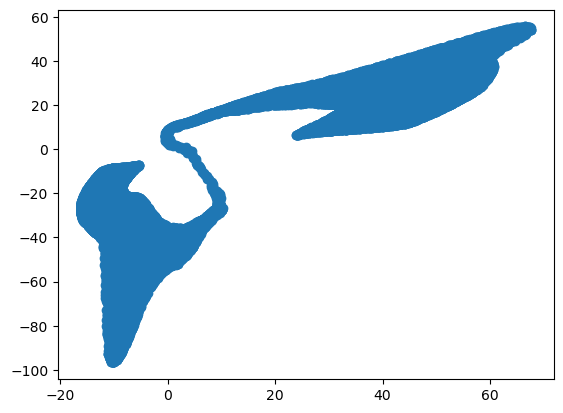

In [22]:
plt.scatter(*latents.T)

In [23]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_3041/4048237539.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


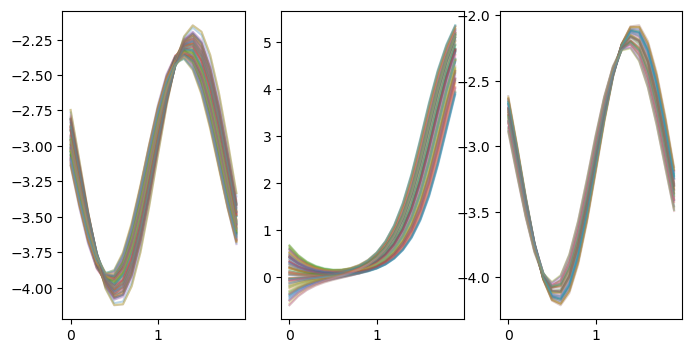

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
plot_most_similar(latents, np.array([-120, 30]), 100, axs[0])
plot_most_similar(latents, np.array([-40, 30]), 100, axs[1])
plot_most_similar(latents, np.array([-60, 0]), 50, axs[2])

In [30]:
_, traj_damped = gen_one_traj(2., .1, np.pi/4, 10., .1)

with torch.no_grad():
    _, latents_damped = te(torch.tensor(traj_damped))
latents_damped

tensor([[109.7144,  92.4162]])

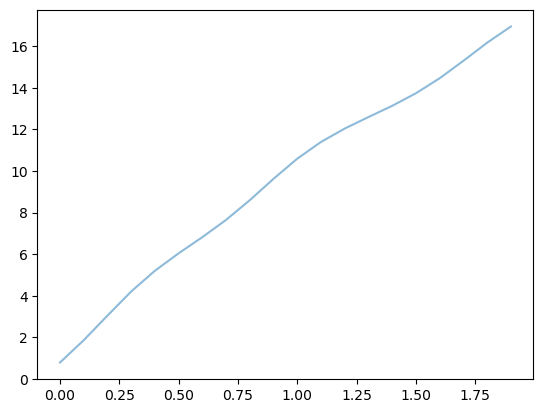

In [31]:
plt.plot(times, traj_damped[0, 0], alpha=.5)

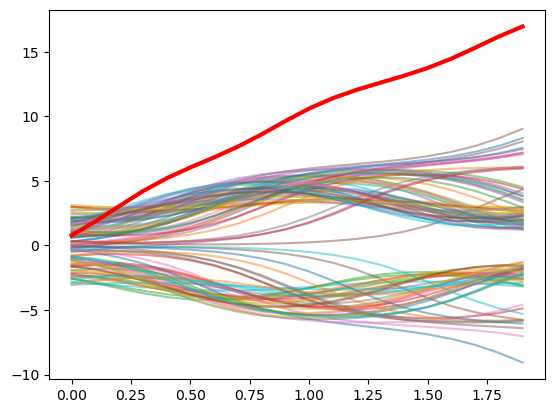

In [32]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_damped[0, 0], color='red', lw=3)

## Using CD poly

In [36]:
from cd_poly.cd_poly import *

In [37]:
p = CDPolynomial(latents, degree=4)
alpha = 1.01 * p(latents).max()

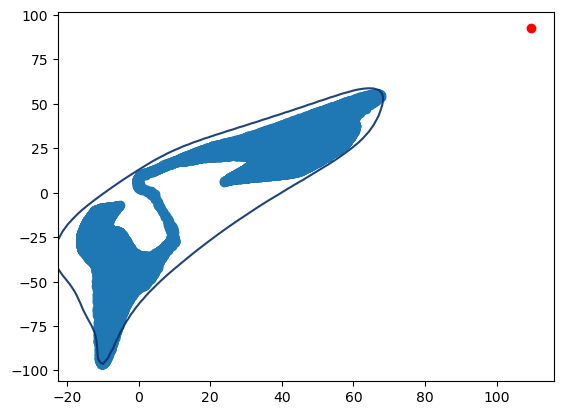

In [38]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_damped.T, color='red')
plot_level_set(p, alpha, ax)